In [2]:
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch
from torch.autograd import Variable

import pandas as pd
import matplotlib.pyplot as plt
import copy
import time
import torch.nn.functional as F

In [100]:
class LogisticRegression(nn.Module):
    """
        Creates a logistic regression model. Features refers to the dimension
        of the inputs, while categories is the number of possible classifications.
    """
    def __init__(self, features, categories):
        super(LogisticRegression, self).__init__()
        # construct and store matrix categories x features
        self.weights = nn.Parameter(torch.zeros(categories, features)) 
        self.biases = nn.Parameter(torch.zeros(categories))
        
    def forward(self, x):
        # takes weights and biases and returns probability vectors
        return F.log_softmax(torch.addmm(self.biases, x, self.weights.transpose(0, 1))) 

In [99]:
class TwoLayerNN(nn.Module):
    """
        Creates a neural net with two hidden layers and a softmax layer. 
        Features refers to the dimension of the inputs, hidden1 and hidden2
        refer to the number of neurons in the two hidden layers (the dimension of those
        layers), and categories refers to the number of possible classifications.
    """
    def __init__(self, features, hidden1, hidden2, categories):
        super(TwoLayerNN, self).__init__()
        self.sigmoid = nn.Sigmoid() # define sigmoid function
        self.layer1 = nn.Linear(features, hidden1) # defines first hidden layer 
        self.layer2 = nn.Linear(hidden1, hidden2) # defines second hidden layer
        self.softmaxlayer = nn.Linear(hidden2, categories) # defines softmax layer
    
    def forward(self, x):
        output1 = self.sigmoid(self.layer1(x)) # computes first layer
        output2 = self.sigmoid(self.layer2(output1)) # computes second layer
        softmax = F.log_softmax(self.softmaxlayer(output2)) # computes log softmax layer
        return softmax

In [16]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

# This is the function to call to train model. It returns the trained model
# and a list of losses.

def train_mnist_model(model, num_epochs=20):
    training_data = pd.read_csv("mnist_train.csv", header = None).values
    training_labels = torch.LongTensor(training_data[:, 0])
    training_values = torch.FloatTensor(training_data[:, 1:].astype(float))
    
    training_dataset = data.TensorDataset(training_values, training_labels)    
    loader_dset_train = data.DataLoader(training_dataset, batch_size=128, 
                                        num_workers=4, shuffle=True)
    
    since = time.time()

    best_model = model
    best_loss = float('inf')
    model.train(True)

    curr_loss = 0.0
    total_batch_number = 0
    all_losses = []
    
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.NLLLoss()
    lr_scheduler = exp_lr_scheduler

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        optimizer = lr_scheduler(optimizer, epoch)

        epoch_running_loss = 0.0
        current_batch = 0
        # Iterate over data.
        for inputs, labels in loader_dset_train:
            current_batch += 1
            total_batch_number += 1

            # wrap them in Variable
            inputs, labels = Variable(inputs), \
                             Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # backward
            loss.backward()
            optimizer.step()

            # statistics
            epoch_running_loss += loss.data[0]
            curr_loss += loss.data[0]

            if total_batch_number % 100 == 0:
                all_losses.append(curr_loss / 100)
                time_elapsed = time.time() - since

                print('Epoch Number: {}, Batch Number: {}, Loss: {:.4f}'.format(
                    epoch, current_batch, curr_loss))
                print('Time so far is {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
                curr_loss = 0.0

        # deep copy the model
        if epoch_running_loss < best_loss:
            best_loss = epoch_running_loss
            best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best loss: {:4f}'.format(best_loss))

    model.train(False)

    return best_model, all_losses

In [101]:
mnist_model1 = LogisticRegression(784, 10)
mnist_model1, losses1 = train_mnist_model(mnist_model1)

Epoch 0/19
----------
LR is set to 0.001
Epoch Number: 0, Batch Number: 100, Loss: 14432.0940
Time so far is 0m 0s
Epoch Number: 0, Batch Number: 200, Loss: 6785.6218
Time so far is 0m 0s
Epoch Number: 0, Batch Number: 300, Loss: 5284.3545
Time so far is 0m 0s
Epoch Number: 0, Batch Number: 400, Loss: 5703.9029
Time so far is 0m 1s

Epoch 1/19
----------
Epoch Number: 1, Batch Number: 31, Loss: 5576.3550
Time so far is 0m 1s
Epoch Number: 1, Batch Number: 131, Loss: 5048.6640
Time so far is 0m 1s
Epoch Number: 1, Batch Number: 231, Loss: 5182.0155
Time so far is 0m 1s
Epoch Number: 1, Batch Number: 331, Loss: 5462.7472
Time so far is 0m 1s
Epoch Number: 1, Batch Number: 431, Loss: 5420.0748
Time so far is 0m 1s

Epoch 2/19
----------
Epoch Number: 2, Batch Number: 62, Loss: 5632.7343
Time so far is 0m 1s
Epoch Number: 2, Batch Number: 162, Loss: 4823.0620
Time so far is 0m 2s
Epoch Number: 2, Batch Number: 262, Loss: 5464.2665
Time so far is 0m 2s
Epoch Number: 2, Batch Number: 362, Lo

In [102]:
mnist_model2 = TwoLayerNN(784, 200, 200, 10)
mnist_model2, losses2 = train_mnist_model(mnist_model2)

Epoch 0/19
----------
LR is set to 0.001
Epoch Number: 0, Batch Number: 100, Loss: 228.3035
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 200, Loss: 220.8570
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 300, Loss: 213.4622
Time so far is 0m 2s
Epoch Number: 0, Batch Number: 400, Loss: 204.9463
Time so far is 0m 2s

Epoch 1/19
----------
Epoch Number: 1, Batch Number: 31, Loss: 194.8935
Time so far is 0m 3s
Epoch Number: 1, Batch Number: 131, Loss: 182.9734
Time so far is 0m 4s
Epoch Number: 1, Batch Number: 231, Loss: 171.3855
Time so far is 0m 4s
Epoch Number: 1, Batch Number: 331, Loss: 157.8285
Time so far is 0m 5s
Epoch Number: 1, Batch Number: 431, Loss: 144.7254
Time so far is 0m 6s

Epoch 2/19
----------
Epoch Number: 2, Batch Number: 62, Loss: 132.8443
Time so far is 0m 7s
Epoch Number: 2, Batch Number: 162, Loss: 122.1539
Time so far is 0m 7s
Epoch Number: 2, Batch Number: 262, Loss: 111.6595
Time so far is 0m 8s
Epoch Number: 2, Batch Number: 362, Loss: 102.6710


In [36]:
test_data = pd.read_csv("mnist_test.csv", header = None).values
test_labels, test_values = torch.LongTensor(test_data[:, 0]), torch.FloatTensor(test_data[:, 1:].astype(float))

test_dataset = data.TensorDataset(test_values, test_labels)    
loader_dset_test = data.DataLoader(test_dataset, batch_size=128, 
                                   num_workers=4, shuffle=True)

In [92]:
"""
    Given a model that classifies data points and a labeled data set
    this determines the accuracy of the model for a specific category. Here,
    accuracy is defined as number of times the model guesses the right category
    for the given category divided by the number of times that category appeared.
    This is more precisely known as the precision.
"""
def accuracy_for_a_category(model, dataset, category):
    positive_results = 0 # create counter for positive results
    total = 0 # create counter for total 
    for datapoint, label in dataset: # creates loop to compute accuracy for all datapoints in dataset
        if label == category:
            total += 1 
            _, guess = torch.max(model(Variable(datapoint)), 0)
            positive_results += torch.sum(guess.data == torch.LongTensor([label]))
    return positive_results/total
            

"""
    Given a list of losses, this creates a plot of the loss curve.
"""
def plot_loss_curve(losses):
    plt.plot(losses) # creates the matplot for losses over time

"""
    Given a model that classifies data points and a labeled data set this
    determines the overall accuracy of the model.
"""
def test_model(model, dataset):
    positive_results = 0
    total = len(dataset)
    for datapoint, label in dataset: 
        _, guess = torch.max(model(Variable(datapoint)), 0)
        positive_results += torch.sum(guess.data == torch.LongTensor([label]))   
    return positive_results/total
   

The accuracy on the digit 0 is 0.98
The accuracy on the digit 1 is 0.98
The accuracy on the digit 2 is 0.90
The accuracy on the digit 3 is 0.90
The accuracy on the digit 4 is 0.93
The accuracy on the digit 5 is 0.84
The accuracy on the digit 6 is 0.94
The accuracy on the digit 7 is 0.92
The accuracy on the digit 8 is 0.87
The accuracy on the digit 9 is 0.89


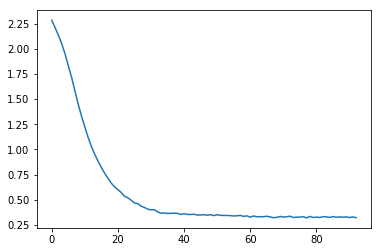

The overall accuracy of the 2 layer neural net on MNIST is 0.92


In [103]:
for i in range(10):
    accuracy_i = accuracy_for_a_category(mnist_model2, test_dataset, i)
    print("The accuracy on the digit {} is {:.2f}".format(i, accuracy_i))

plot_loss_curve(losses2)
plt.show()

accuracy = test_model(mnist_model2, test_dataset)
print("The overall accuracy of the 2 layer neural net on MNIST is {:.2f}".format(accuracy))